<a href="https://colab.research.google.com/github/myllanes/Introduction-to-Deep-Learning/blob/main/HW2_ALEXNET_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/100], Training Loss: 4.2894
Validation Loss: 3.9790, Validation Accuracy: 7.39%
Epoch [2/100], Training Loss: 3.8604
Validation Loss: 3.6017, Validation Accuracy: 14.21%
Epoch [3/100], Training Loss: 3.5734
Validation Loss: 3.3587, Validation Accuracy: 18.69%
Epoch [4/100], Training Loss: 3.4063
Validation Loss: 3.2195, Validation Accuracy: 21.51%
Epoch [5/100], Training Loss: 3.2768
Validation Loss: 3.0625, Validation Accuracy: 24.93%
Epoch [6/100], Training Loss: 3.1873
Validation Loss: 3.0128, Validation Accuracy: 26.25%
Epoch [7/100], Training Loss: 3.1061
Validation Loss: 2.9268, Validation Accuracy: 27.48%
Epoch [8/100], Training Loss: 3.0391
Validation Loss: 2.7808, Validation Accuracy: 30.00%
Epoch [9/100], Training Loss: 2.9804
Validation Loss: 2.7849, Validation Accuracy: 30.36%
Epoch [10/100], Training Loss: 2.9423
Validation Loss: 2.7634, Validation Accuracy: 31.18%
Epoch [11/

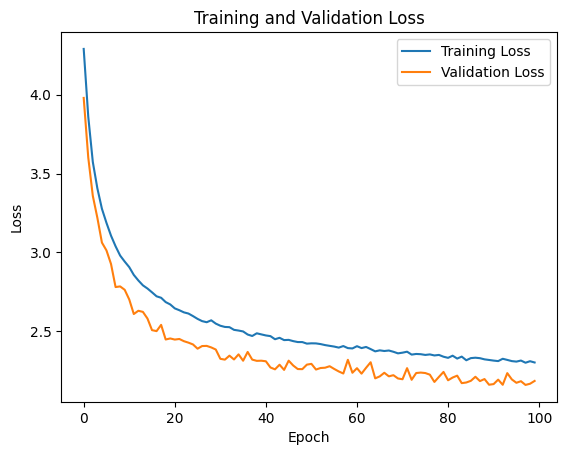

Total number of parameters: 5866468


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Define the modified AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DROPOUT

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DROPOUT

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DROPOUT

        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5), #DROPOUT

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5), #DROPOUT

            nn.Linear(512, 100),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_val_loss = val_loss / len(test_loader)
    val_loss_list.append(epoch_val_loss)

    val_accuracy = 100. * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]:.2f}%')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

